In [1]:
import sys
import sqlite3

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [3]:
di = 'SPEI'
di_scale = 24

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'GPM_Precipitation',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
 ]

In [4]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [5]:
# selected_stations = ['Ramsar', 'Nowshahr']
selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_24,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,LSTDay,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month
0,Siahbisheh,40735,36.231,51.303,1855.4,2008-08-01,0.428,13.392,253.712,0.365,...,37.99,11.99,24.990,0.129,0.000,0.175,0.088,0.102,2008,8
1,Siahbisheh,40735,36.231,51.303,1855.4,2008-09-01,0.510,48.960,190.988,0.279,...,31.65,9.23,20.440,0.760,0.000,0.560,0.280,0.440,2008,9
2,Siahbisheh,40735,36.231,51.303,1855.4,2008-10-01,0.310,73.656,112.550,0.245,...,25.58,5.74,15.660,0.575,0.000,0.458,0.229,0.344,2008,10
3,Siahbisheh,40735,36.231,51.303,1855.4,2008-11-01,0.109,63.360,60.075,0.178,...,11.06,-1.74,4.660,0.328,0.150,0.387,0.269,0.288,2008,11
4,Siahbisheh,40735,36.231,51.303,1855.4,2008-12-01,0.181,88.536,50.588,0.243,...,-5.06,-4.76,-4.910,1.000,0.628,0.917,0.773,0.848,2008,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.034,34.224,201.938,0.469,...,30.68,11.31,20.995,0.441,0.000,0.141,0.070,0.194,2023,5
906,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.778,29.520,247.350,0.461,...,29.42,13.02,21.220,0.462,0.236,0.836,0.536,0.511,2023,6
907,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.888,15.624,259.525,0.466,...,31.65,14.71,23.180,0.215,0.573,0.767,0.670,0.518,2023,7
908,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-1.978,20.088,239.275,0.420,...,34.26,14.97,24.615,0.222,0.537,0.274,0.406,0.345,2023,8


In [7]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_24,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month,SPEI_24_Class
0,Siahbisheh,40735,36.231,51.303,1855.4,2008-08-01,0.428,13.392,253.712,0.365,...,11.99,24.990,0.129,0.000,0.175,0.088,0.102,2008,8,NN
1,Siahbisheh,40735,36.231,51.303,1855.4,2008-09-01,0.510,48.960,190.988,0.279,...,9.23,20.440,0.760,0.000,0.560,0.280,0.440,2008,9,NN
2,Siahbisheh,40735,36.231,51.303,1855.4,2008-10-01,0.310,73.656,112.550,0.245,...,5.74,15.660,0.575,0.000,0.458,0.229,0.344,2008,10,NN
3,Siahbisheh,40735,36.231,51.303,1855.4,2008-11-01,0.109,63.360,60.075,0.178,...,-1.74,4.660,0.328,0.150,0.387,0.269,0.288,2008,11,NN
4,Siahbisheh,40735,36.231,51.303,1855.4,2008-12-01,0.181,88.536,50.588,0.243,...,-4.76,-4.910,1.000,0.628,0.917,0.773,0.848,2008,12,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.034,34.224,201.938,0.469,...,11.31,20.995,0.441,0.000,0.141,0.070,0.194,2023,5,ED
906,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.778,29.520,247.350,0.461,...,13.02,21.220,0.462,0.236,0.836,0.536,0.511,2023,6,SD
907,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.888,15.624,259.525,0.466,...,14.71,23.180,0.215,0.573,0.767,0.670,0.518,2023,7,SD
908,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-1.978,20.088,239.275,0.420,...,14.97,24.615,0.222,0.537,0.274,0.406,0.345,2023,8,SD


In [8]:
cols_to_lag = ['GPM_Precipitation', 'PET_MOD16A2GF', 'NDVI', 'EVI', 'VHI', 'LST', 'PCI_GPM', 'TCI', 'VHI', 'CI_GPM']
for lag in range(1, 4):
    for col in cols_to_lag:
        # Important: Group by Station_ID to prevent data leakage across stations
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_24,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,CI_GPM_lag_2,GPM_Precipitation_lag_3,PET_MOD16A2GF_lag_3,NDVI_lag_3,EVI_lag_3,VHI_lag_3,LST_lag_3,PCI_GPM_lag_3,TCI_lag_3,CI_GPM_lag_3
0,Siahbisheh,40735,36.231,51.303,1855.4,2008-08-01,0.428,13.392,253.712,0.365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Siahbisheh,40735,36.231,51.303,1855.4,2008-09-01,0.510,48.960,190.988,0.279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Siahbisheh,40735,36.231,51.303,1855.4,2008-10-01,0.310,73.656,112.550,0.245,...,0.102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Siahbisheh,40735,36.231,51.303,1855.4,2008-11-01,0.109,63.360,60.075,0.178,...,0.440,13.392,253.712,0.365,0.193,0.088,24.990,0.129,0.175,0.102
4,Siahbisheh,40735,36.231,51.303,1855.4,2008-12-01,0.181,88.536,50.588,0.243,...,0.344,48.960,190.988,0.279,0.154,0.280,20.440,0.760,0.560,0.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.034,34.224,201.938,0.469,...,0.116,55.776,105.225,0.252,0.117,0.479,4.975,0.401,0.447,0.453
906,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.778,29.520,247.350,0.461,...,0.200,45.384,142.175,0.291,0.134,0.043,12.915,0.264,0.000,0.116
907,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.888,15.624,259.525,0.466,...,0.194,23.760,178.512,0.459,0.252,0.210,17.015,0.180,0.012,0.200
908,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-1.978,20.088,239.275,0.420,...,0.511,34.224,201.938,0.469,0.287,0.070,20.995,0.441,0.141,0.194


In [9]:
for col in cols_to_lag:
    # روش محاسبه با استفاده از transform اصلاح شد تا از خطا جلوگیری شود
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())


/tmp/ipykernel_391995/572975484.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'{col}_roll_mean_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
/tmp/ipykernel_391995/572975484.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'{col}_roll_std_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
/tmp/ipykernel_391995/572975484.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

In [10]:
df['Month'] = df['Month'].astype('int')
df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)
df['Month'] = df['Month'].astype('category')

In [11]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y = df[f'{di}_{di_scale}']

In [12]:
X

,Station_Latitude,Station_Longitude,Station_Elevation,GPM_Precipitation,PET_MOD16A2GF,NDVI,EVI,LSTDay,LSTNight,LST,...,LST_roll_mean_3,LST_roll_std_3,PCI_GPM_roll_mean_3,PCI_GPM_roll_std_3,TCI_roll_mean_3,TCI_roll_std_3,CI_GPM_roll_mean_3,CI_GPM_roll_std_3,month_sin,month_cos
0,36.231,51.303,1855.4,63.360,60.075,0.178,0.059,11.06,-1.74,4.660,...,13.586667,8.091732,0.554333,0.216740,0.468333,0.086962,0.357333,0.076872,-5.000000e-01,8.660254e-01
1,36.231,51.303,1855.4,88.536,50.588,0.243,0.041,-5.06,-4.76,-4.910,...,5.136667,10.293281,0.634333,0.339906,0.587333,0.287698,0.493333,0.308424,-2.449294e-16,1.000000e+00
2,36.231,51.303,1855.4,49.848,57.612,0.187,0.058,-5.59,-6.17,-5.880,...,-2.043333,5.825481,0.596667,0.355665,0.630667,0.267564,0.572000,0.280086,5.000000e-01,8.660254e-01
3,36.231,51.303,1855.4,73.248,80.100,0.179,0.056,0.60,-5.43,-2.415,...,-4.401667,1.787557,0.616667,0.334032,0.681667,0.205213,0.645667,0.178786,8.660254e-01,5.000000e-01
4,36.231,51.303,1855.4,51.336,136.212,0.159,0.076,18.42,-0.45,8.985,...,0.230000,7.777472,0.395333,0.063319,0.434000,0.226442,0.431667,0.198631,1.000000e+00,6.123234e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,36.071,52.843,1805.0,34.224,201.938,0.469,0.287,30.68,11.31,20.995,...,16.975000,4.040149,0.295000,0.133233,0.051000,0.078173,0.170000,0.046861,5.000000e-01,-8.660254e-01
891,36.071,52.843,1805.0,29.520,247.350,0.461,0.257,29.42,13.02,21.220,...,19.743333,2.365483,0.361000,0.157102,0.329667,0.443216,0.301667,0.181313,1.224647e-16,-1.000000e+00
892,36.071,52.843,1805.0,15.624,259.525,0.466,0.259,31.65,14.71,23.180,...,21.798333,1.201835,0.372667,0.136946,0.581333,0.382897,0.407667,0.185074,-5.000000e-01,-8.660254e-01
893,36.071,52.843,1805.0,20.088,239.275,0.420,0.219,34.26,14.97,24.615,...,23.005000,1.704252,0.299667,0.140628,0.625667,0.306500,0.458000,0.097923,-8.660254e-01,-5.000000e-01


# Stacking Meta-Model


--- Performing Automatic Feature Selection with RFECV ---
Optimal number of features found by RFECV: 27
Optimal number (27) is greater than the cap (10).
Selecting top 10 features using RFE.
Final selected features: ['PET_MOD16A2GF_lag_2', 'GPM_Precipitation_lag_3', 'NDVI_lag_3', 'VHI_lag_3', 'GPM_Precipitation_roll_std_3', 'VHI_roll_mean_3', 'PCI_GPM_roll_std_3', 'TCI_roll_mean_3', 'TCI_roll_std_3', 'CI_GPM_roll_mean_3']

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters found:  {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}

Training the final RandomForestRegressor model...

Evaluating the final model...

--- Final Model Evaluation Metrics (RandomForestRegressor) ---
R-squared (R²): 0.2449
Root Mean Squared Error (RMSE): 0.8073
Mean Absolute Error (MAE): 0.6609


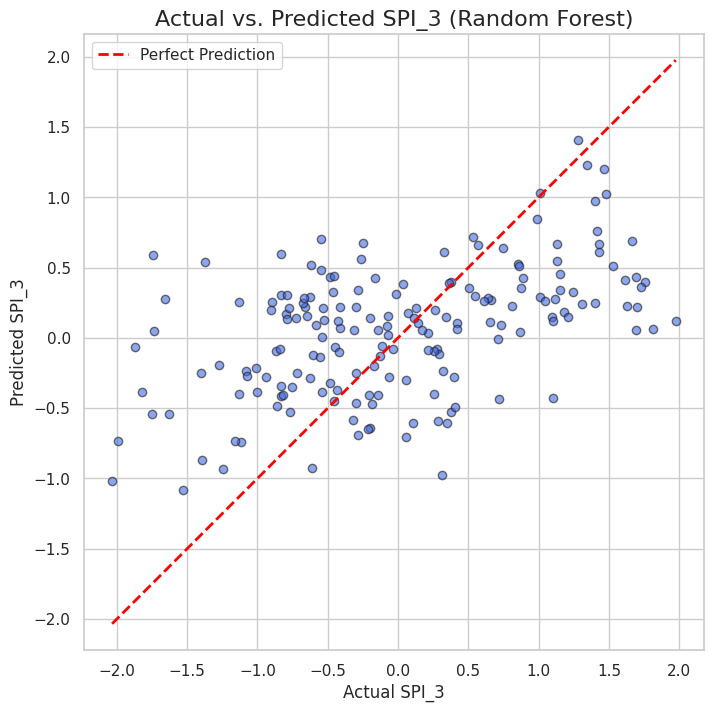

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# کتابخانه های مورد نیاز برای مدل RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFECV, RFE

# --- 3. Data Splitting and Feature Selection ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

# انتخاب خودکار بهترین تعداد ویژگی با RFECV برای رگرسیون
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)
max_features_cap = 10 

selector_cv = RFECV(estimator, step=1, cv=KFold(3), scoring='neg_mean_squared_error', min_features_to_select=5, n_jobs=-1)
selector_cv = selector_cv.fit(X_train, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

if optimal_n_features > max_features_cap:
    print(f"Optimal number ({optimal_n_features}) is greater than the cap ({max_features_cap}).")
    print(f"Selecting top {max_features_cap} features using RFE.")
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train, y_train)
else:
    print("Optimal number is within the cap. Using RFECV selection.")
    selector = selector_cv

selected_features = X_train.columns[selector.support_]
print("Final selected features:", list(selected_features))

X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# --- 4. Hyperparameter Tuning for RandomForestRegressor ---
print("\n--- Starting Hyperparameter Tuning ---")
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 1.0]
}

rf_reg = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf_reg,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_selected, y_train)
print("\nBest Hyperparameters found: ", random_search.best_params_)

# --- 5. Train the Final Model ---
print("\nTraining the final RandomForestRegressor model...")
best_model = random_search.best_estimator_
best_model.fit(X_train_selected, y_train)

# --- 6. Prediction and Evaluation ---
print("\nEvaluating the final model...")
y_pred = best_model.predict(X_test_selected)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n--- Final Model Evaluation Metrics (RandomForestRegressor) ---")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

# --- 7. Visualization ---
sns.set_theme(style="whitegrid")

# نمودار مقادیر واقعی در برابر پیش بینی شده
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='royalblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted SPI_3 (Random Forest)', fontsize=16)
plt.xlabel('Actual SPI_3', fontsize=12)
plt.ylabel('Predicted SPI_3', fontsize=12)
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()
